In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
num_iterations = 50 if smoke_test else 100
num_samples = 20 if smoke_test else 100
num_steps = 100 if smoke_test else 400
sample_size = 100 if smoke_test else 300
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

In [2]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]


def get_count_data_subset(count_data, start, end):
    count_subset = {key: count_data[key][start:end] for key in count_data.keys()}
    init_state = {key[:-4]: count_subset[key][0] for key in count_subset.keys()}

    return {"count_subset": count_subset, "init_state": init_state}


[90, 100, 110, 120, 130, 140, 150, 160]
running inference for  s80_e90_steps400


/home/rafal/miniconda3/envs/collab/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'counts_obs'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Running SVI for 400 steps...
[iteration 0001] loss: 109.6778
[iteration 0002] loss: 124.9609
[iteration 0004] loss: 105.3922
[iteration 0006] loss: 114.1620
[iteration 0008] loss: 105.0578
[iteration 0010] loss: 107.5241
[iteration 0012] loss: 110.5497
[iteration 0014] loss: 112.3929
[iteration 0016] loss: 113.6271
[iteration 0018] loss: 98.5904
[iteration 0020] loss: 116.8803
[iteration 0022] loss: 93.4205
[iteration 0024] loss: 85.3717
[iteration 0026] loss: 93.3457
[iteration 0028] loss: 84.1550
[iteration 0030] loss: 88.5891
[iteration 0032] loss: 89.6891
[iteration 0034] loss: 105.3717
[iteration 0036] loss: 91.1478
[iteration 0038] loss: 84.1832
[iteration 0040] loss: 99.6916
[iteration 0042] loss: 94.1790
[iteration 0044] loss: 74.2267
[iteration 0046] loss: 61.8234
[iteration 0048] loss: 79.6708
[iteration 0050] loss: 88.3491
[iteration 0052] loss: 87.2771
[iteration 0054] loss: 79.3005
[iteration 0056] loss: 89.4965
[iteration 0058] loss: 96.8825
[iteration 0060] loss: 71.3106

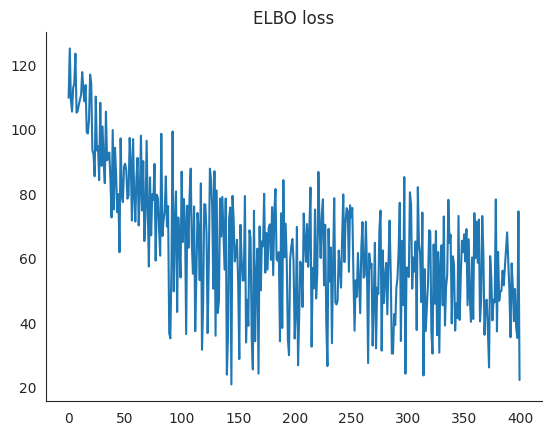

running inference for  s80_e100_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 183.6553
[iteration 0002] loss: 191.5270
[iteration 0004] loss: 189.2744
[iteration 0006] loss: 194.5303
[iteration 0008] loss: 186.8179
[iteration 0010] loss: 179.8084
[iteration 0012] loss: 175.5596
[iteration 0014] loss: 180.2385
[iteration 0016] loss: 184.0150
[iteration 0018] loss: 177.1374
[iteration 0020] loss: 190.5993
[iteration 0022] loss: 183.5700
[iteration 0024] loss: 190.8838
[iteration 0026] loss: 187.5620
[iteration 0028] loss: 171.3826
[iteration 0030] loss: 171.1526
[iteration 0032] loss: 169.0614
[iteration 0034] loss: 171.7074
[iteration 0036] loss: 169.4574
[iteration 0038] loss: 170.0797
[iteration 0040] loss: 160.1599
[iteration 0042] loss: 146.1731
[iteration 0044] loss: 155.6976
[iteration 0046] loss: 176.6534
[iteration 0048] loss: 177.1019
[iteration 0050] loss: 152.5846
[iteration 0052] loss: 146.6973
[iteration 0054] loss: 158.7712
[iteration 0056] loss: 126.5350
[i

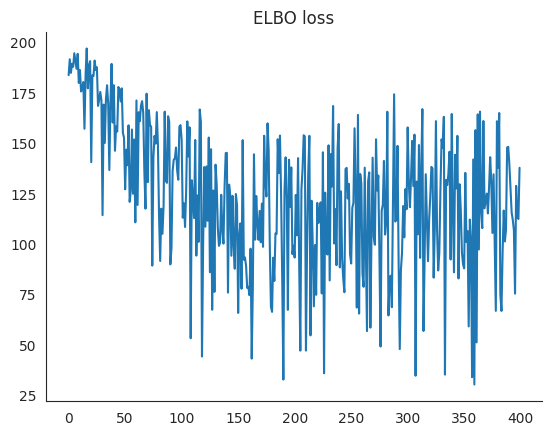

running inference for  s80_e110_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 207.2047
[iteration 0002] loss: 220.9967
[iteration 0004] loss: 221.0823
[iteration 0006] loss: 195.3708
[iteration 0008] loss: 194.4868
[iteration 0010] loss: 202.0167
[iteration 0012] loss: 203.2782
[iteration 0014] loss: 190.3424
[iteration 0016] loss: 203.7074
[iteration 0018] loss: 208.0857
[iteration 0020] loss: 176.6005
[iteration 0022] loss: 180.8706
[iteration 0024] loss: 170.8987
[iteration 0026] loss: 169.3360
[iteration 0028] loss: 202.3405
[iteration 0030] loss: 187.9569
[iteration 0032] loss: 171.6857
[iteration 0034] loss: 177.3229
[iteration 0036] loss: 165.2727
[iteration 0038] loss: 181.8079
[iteration 0040] loss: 164.8397
[iteration 0042] loss: 176.9113
[iteration 0044] loss: 172.9716
[iteration 0046] loss: 152.6475
[iteration 0048] loss: 163.6871
[iteration 0050] loss: 141.4039
[iteration 0052] loss: 167.4226
[iteration 0054] loss: 161.6630
[iteration 0056] loss: 113.6220
[i

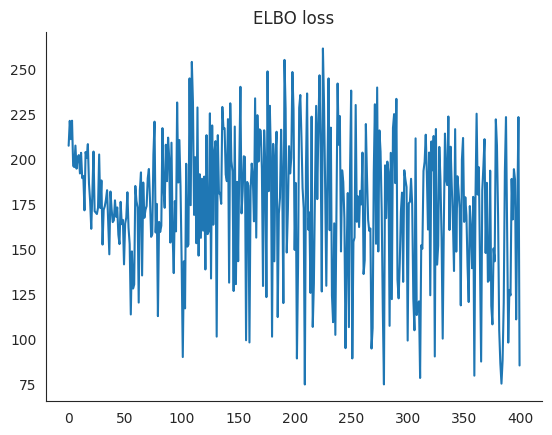

running inference for  s80_e120_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 301.7390
[iteration 0002] loss: 277.6483
[iteration 0004] loss: 309.1192
[iteration 0006] loss: 295.3596
[iteration 0008] loss: 288.3067
[iteration 0010] loss: 287.3556
[iteration 0012] loss: 311.2184
[iteration 0014] loss: 293.3085
[iteration 0016] loss: 299.7997
[iteration 0018] loss: 266.5091
[iteration 0020] loss: 305.2049
[iteration 0022] loss: 299.0617
[iteration 0024] loss: 309.1002
[iteration 0026] loss: 299.7019
[iteration 0028] loss: 270.2761
[iteration 0030] loss: 305.3071
[iteration 0032] loss: 262.1044
[iteration 0034] loss: 289.2226
[iteration 0036] loss: 294.2838
[iteration 0038] loss: 284.6888
[iteration 0040] loss: 286.1693
[iteration 0042] loss: 287.9260
[iteration 0044] loss: 255.2387
[iteration 0046] loss: 251.4918
[iteration 0048] loss: 222.8631
[iteration 0050] loss: 293.8307
[iteration 0052] loss: 307.7357
[iteration 0054] loss: 308.5546
[iteration 0056] loss: 270.5341
[i

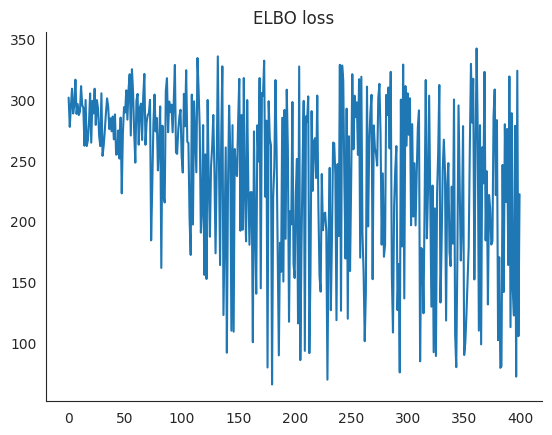

running inference for  s80_e130_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 416.5596
[iteration 0002] loss: 414.4671
[iteration 0004] loss: 423.3077
[iteration 0006] loss: 416.3330
[iteration 0008] loss: 425.1687
[iteration 0010] loss: 397.9288
[iteration 0012] loss: 391.0804
[iteration 0014] loss: 405.9145
[iteration 0016] loss: 402.6669
[iteration 0018] loss: 409.8906
[iteration 0020] loss: 414.4409
[iteration 0022] loss: 394.5084
[iteration 0024] loss: 412.1082
[iteration 0026] loss: 394.8326
[iteration 0028] loss: 413.7330
[iteration 0030] loss: 372.6365
[iteration 0032] loss: 385.7499
[iteration 0034] loss: 427.5706
[iteration 0036] loss: 370.6407
[iteration 0038] loss: 391.5493
[iteration 0040] loss: 413.4644
[iteration 0042] loss: 398.2656
[iteration 0044] loss: 410.8670
[iteration 0046] loss: 407.2072
[iteration 0048] loss: 358.0812
[iteration 0050] loss: 368.5759
[iteration 0052] loss: 360.4174
[iteration 0054] loss: 356.0802
[iteration 0056] loss: 390.1650
[i

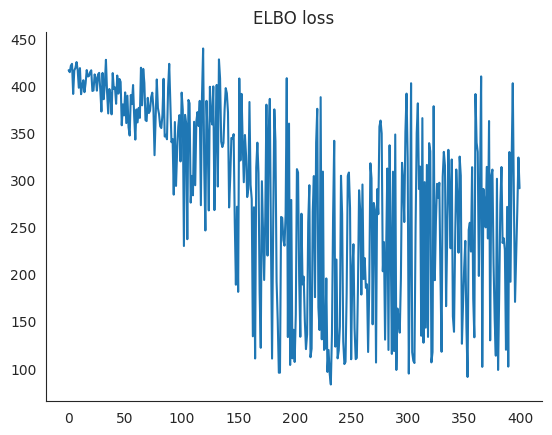

running inference for  s80_e140_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 449.5474
[iteration 0002] loss: 472.1016
[iteration 0004] loss: 468.6561
[iteration 0006] loss: 432.3104
[iteration 0008] loss: 445.8921
[iteration 0010] loss: 462.2476
[iteration 0012] loss: 458.0789
[iteration 0014] loss: 449.9574
[iteration 0016] loss: 459.3825
[iteration 0018] loss: 439.0772
[iteration 0020] loss: 447.0481
[iteration 0022] loss: 454.0222
[iteration 0024] loss: 453.2997
[iteration 0026] loss: 452.1544
[iteration 0028] loss: 416.9021
[iteration 0030] loss: 443.4504
[iteration 0032] loss: 439.2520
[iteration 0034] loss: 425.6897
[iteration 0036] loss: 396.5709
[iteration 0038] loss: 475.1292
[iteration 0040] loss: 410.8886
[iteration 0042] loss: 362.2203
[iteration 0044] loss: 480.4905
[iteration 0046] loss: 438.0113
[iteration 0048] loss: 379.1611
[iteration 0050] loss: 430.0116
[iteration 0052] loss: 474.6693
[iteration 0054] loss: 453.3306
[iteration 0056] loss: 462.6799
[i

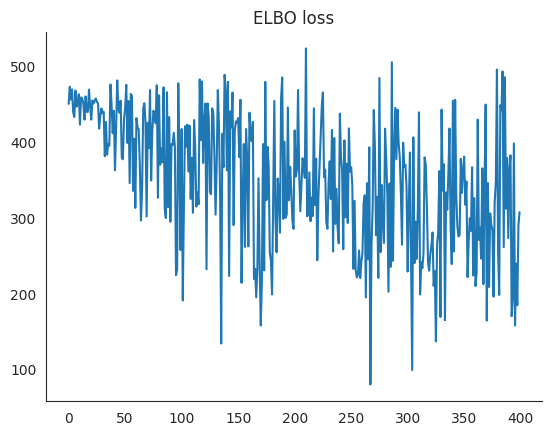

running inference for  s80_e150_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 545.2159
[iteration 0002] loss: 566.8214
[iteration 0004] loss: 551.0623
[iteration 0006] loss: 559.4948
[iteration 0008] loss: 541.1860
[iteration 0010] loss: 557.0549
[iteration 0012] loss: 546.0229
[iteration 0014] loss: 535.7357
[iteration 0016] loss: 534.8699
[iteration 0018] loss: 559.9302
[iteration 0020] loss: 550.1736
[iteration 0022] loss: 556.7876
[iteration 0024] loss: 522.6504
[iteration 0026] loss: 524.1651
[iteration 0028] loss: 497.9946
[iteration 0030] loss: 497.7225
[iteration 0032] loss: 487.4776
[iteration 0034] loss: 511.3038
[iteration 0036] loss: 521.2299
[iteration 0038] loss: 499.7606
[iteration 0040] loss: 445.8201
[iteration 0042] loss: 494.0557
[iteration 0044] loss: 439.1627
[iteration 0046] loss: 465.3953
[iteration 0048] loss: 515.6841
[iteration 0050] loss: 444.4118
[iteration 0052] loss: 494.9465
[iteration 0054] loss: 442.0395
[iteration 0056] loss: 448.1166
[i

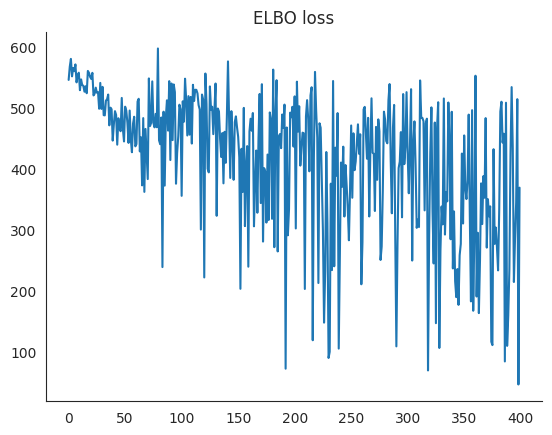

running inference for  s80_e160_steps400
Running SVI for 400 steps...
[iteration 0001] loss: 407.9079
[iteration 0002] loss: 432.3908
[iteration 0004] loss: 404.9081
[iteration 0006] loss: 454.6979
[iteration 0008] loss: 484.6357
[iteration 0010] loss: 415.3520
[iteration 0012] loss: 474.1969
[iteration 0014] loss: 550.2567
[iteration 0016] loss: 459.5026
[iteration 0018] loss: 534.6549
[iteration 0020] loss: 493.9913
[iteration 0022] loss: 485.5343
[iteration 0024] loss: 503.8062
[iteration 0026] loss: 423.0684
[iteration 0028] loss: 398.2672
[iteration 0030] loss: 371.8566
[iteration 0032] loss: 471.0327
[iteration 0034] loss: 495.4385
[iteration 0036] loss: 460.6959
[iteration 0038] loss: 410.6223
[iteration 0040] loss: 436.8717
[iteration 0042] loss: 491.9984
[iteration 0044] loss: 471.5078
[iteration 0046] loss: 502.4134
[iteration 0048] loss: 406.5346
[iteration 0050] loss: 421.8204
[iteration 0052] loss: 424.5724
[iteration 0054] loss: 500.8796
[iteration 0056] loss: 443.8244
[i

ValueError: Expected parameter loc (Tensor of shape (15,)) of distribution MultivariateNormal(loc: torch.Size([15]), scale_tril: torch.Size([15, 15])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<ExpandBackward0>)
                    Trace Shapes:      
                     Param Sites:      
     AutoMultivariateNormal.scale    15
AutoMultivariateNormal.scale_tril 15 15
       AutoMultivariateNormal.loc    15
                    Sample Sites:      

In [27]:

piecemeal_path = os.path.join(root, "data/foraging/locust/ds/time_slices/")

samples_file_path = os.path.join(piecemeal_path, "samples.pkl")
if os.path.exists(samples_file_path):
    with open(samples_file_path, 'rb') as file:
        samples = dill.load(file)
else:
    print("No samples file found, creating new dict")
    samples = {}

start = 80
ends = [start + end for end in [10, 20, 30, 40, 50, 60, 70, 80]]
step_size = 1

for end in ends:
    if f"s{start}_e{end}_steps{num_steps}" not in samples.keys():

        start_time = torch.tensor(1).float()
        end_time = torch.tensor(250 + 1).float()

        c_data = get_count_data_subset(count_data, start, end)

        logging_times = torch.arange(start, end, step_size)

        print("running inference for ", f"s{start}_e{end}_steps{num_steps}")
        guide = ft.run_svi_inference(
                model=lc.conditioned_locust_model,
                num_steps=num_steps,
                verbose=True,
                lr=0.03,
                blocked_sites=["counts_obs"],
                obs_times=logging_times,
                data=c_data['count_subset'],
                init_state=c_data['init_state'],
                start_time=start_time,
            )


        predictive = Predictive(
            lc.simulated_bayesian_locust, guide=guide,
            num_samples=num_samples
        )

        samples[f"s{start}_e{end}_steps{num_steps}"] = predictive(c_data['init_state'], 
                                                            start_time, logging_times)

        with open(samples_file_path, 'wb') as file:
            dill.dump(samples, file)


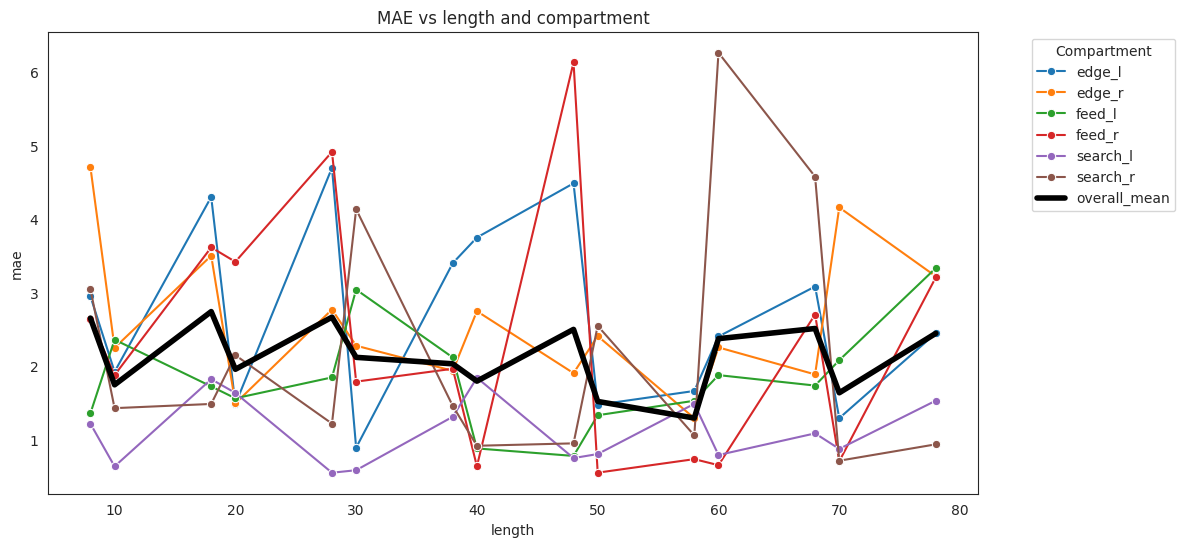

In [78]:
import re
import pandas as pd

samples_400 =  {key: value for key, value in samples.items() if key.endswith('400')}
samples_400.keys()

pattern = re.compile(r's(\d+)_e(\d+)_steps(\d+)')



df = pd.DataFrame(columns=['start', 'end', 'length','edge_l', 'edge_r', 'feed_l', 'feed_r', 'search_l', 'search_r', 'overall_mean'])


for key, value in samples_400.items():
    match = pattern.match(key)
    start = int(match.group(1))
    end = int(match.group(2))
    if start == 0:
        start += 1
        end -= 1
    count_subset = get_count_data_subset(count_data, start, end)['count_subset']


    mean_preds = {}
    abs_errors = {}
    maes = {}
    for compartment in ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]:
        mean_preds[compartment] = value[compartment].mean(dim=0)
        abs_errors[compartment] = torch.abs(count_subset[f"{compartment}_obs"] - mean_preds[compartment])
        maes[compartment] = abs_errors[compartment].mean()
    all_errors = torch.cat([tensor for tensor in abs_errors.values()])
    overall_mean = torch.mean(all_errors).item()
    df.loc[key] = [start, end, end - start] +[maes[var].item() for var in df.columns[3:-1]] +  [overall_mean]


df_for_plot = df.melt(id_vars=['length'], value_vars=df.columns[3:-1], var_name='compartment', value_name='MAE')

plt.figure(figsize=(12, 6))
sns.lineplot(x='length', y='MAE', hue='compartment', data=df_for_plot, marker='o')

sns.lineplot(x=df['length'], y=df['overall_mean'], label='overall_mean', 
             linewidth=4.0, color='black')  

plt.xlabel('length')
plt.ylabel('mae')
plt.title('MAE vs length and compartment')
plt.legend(title='Compartment', bbox_to_anchor=(1.05, 1), loc='upper left')



plt.show()

{'edge_l': tensor(1.7380, dtype=torch.float64), 'edge_r': tensor(1.3085, dtype=torch.float64), 'feed_l': tensor(1.4790, dtype=torch.float64), 'feed_r': tensor(0.7345, dtype=torch.float64), 'search_l': tensor(1.5126, dtype=torch.float64), 'search_r': tensor(1.1074, dtype=torch.float64)}


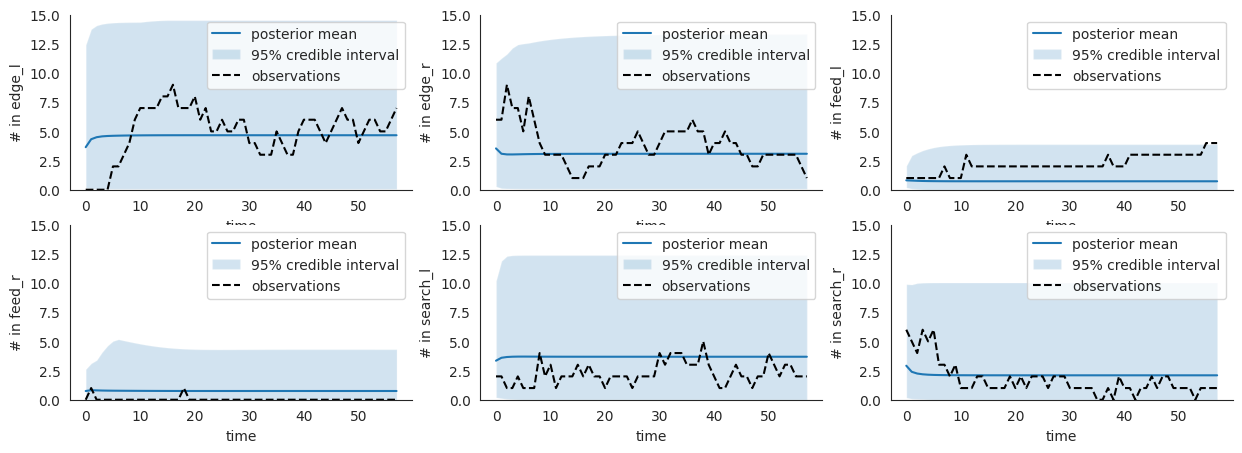

In [24]:
start, end, num_steps = 0, 60, 400
batch = f"s{start}_e{end}_steps{num_steps}"
subsamples = samples[batch]
count_subset = get_count_data_subset(count_data, start, end)['count_subset']


mean_preds = {}
abs_errors = {}
maes = {}
for key in ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]:
    mean_preds[key] = subsamples[key].mean(dim=0)
    abs_errors[key] = torch.abs(count_subset[f"{key}_obs"][:-2] - mean_preds[key])
    maes[key] = abs_errors[key].mean()

print(maes)


fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax = ax.flatten()

for i, state, color in zip(
    range(6),
    ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
    ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
):
    ft.ds_uncertainty_plot(
        state_pred=subsamples[state],
        data=count_subset[f"{state}_obs"][:-2], #TODO this is hacky
        ylabel=f"# in {state}",
        color=color,
        data_label="observations",
        ax=ax[i],
        legend=True,
        test_plot=False,
        mean_label="posterior mean",
        ylim = 15
    )

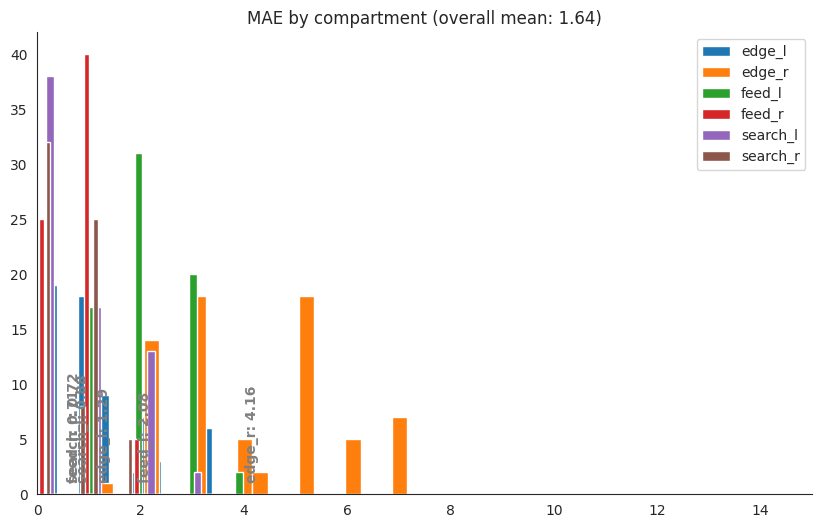

In [79]:
all_errors = torch.cat([tensor for tensor in abs_errors.values()])
overall_mean = torch.mean(all_errors).item()

plt.figure(figsize=(10, 6))
for key, tensor in abs_errors.items():
    plt.hist(tensor, label=key, bins=20)

for key, tensor in abs_errors.items():
    mean = torch.mean(tensor).item()
    plt.text(mean, 1, f'{key}: {mean:.2f}', rotation=90, va='bottom', ha='center', color='gray', weight='bold')

plt.title(f"MAE by compartment (overall mean: {overall_mean:.2f})")

plt.xlim(0, 15)
sns.despine()
plt.legend()
plt.show()

